# Colab データインストール

In [0]:
# 以下を実行すると、認証情報を取得するための許可を求められるので、許可してトークンを発行し、テキストボックスに貼り付ける。
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [2]:
# Colabにおいてデータを読みこむ。グーグルドライブをマウントします。その為に必要なパッケージを取得しておく。
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


gpg: keybox '/tmp/tmpjzgnst9d/pubring.gpg' created
gpg: /tmp/tmpjzgnst9d/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [5]:
# 以下実行により、今度は google-drive-ocamlfuse によるアクセスの許可を聞かれる。これも許可する。
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [6]:
# 今回は指定したフォルダのみマウントする
!cp -f ~/.gdfuse/default/config config
!sed -i -e "s/^root_folder=$/root_folder=1FwGdPnKlcYYRe1mZGE5Ci-PWlIY8k5J7/" config
# 上記が正常に終われば、ようやくマウントが可能となる。
!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive
!ls drive

Clearing cache...done
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
compare-deeplibs.ipynb	    dataset	week3-EDA
dataマウントテンプレ.ipynb  test.ipynb	week4


In [1]:
# これ以降はターミナルと同様にディレクトリを扱える
cd drive/dataset

/content/drive/dataset


In [2]:
ls

Home Credit Default Risk/  Mercedes-Benz Greener Manufacturing/
House Prices_data/         Porto Seguro’s Safe Driver Prediction/
Instacart Market Basket/   Titanic/


In [3]:
cd House Prices_data

/content/drive/dataset/House Prices_data


In [4]:
ls

data_description.odt   sample_submission.csv.gz  train.csv
data_description.txt   test.csv                  train.csv.gz
sample_submission.csv  test.csv.gz               train.ods


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# House Prices: Advanced Regression Techniques

①Question or problem definition.
②Acquire training and testing data.
③Wrangle, prepare, cleanse the data.
④Analyze, identify patterns, and explore the data.
⑤Model, predict and solve the problem.
⑥Visualize, report, and present the problem solving steps and final solution.
Supply or submit the results.

まずはデータを読み込みましょう。

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

では実際にデータを見ていきましょう。

In [8]:
# trainデータの概要
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# testデータの概要
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
# trainデータの概要を見る
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


trainデータは８１個の特徴量を1460行、有しており、
testデータは８0個の特徴量を1460行、有していることがわかりました。
どうやらtestデータにはSalePriceに関するデータが入っていないようです。

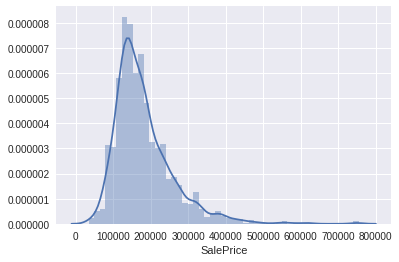

In [11]:
# SalaPriceのhistを見る
sns.distplot(train['SalePrice'])

In [12]:
# SalePriceのskewとkurtを見る
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


In [13]:
# trainデータの欠損値の確認
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [14]:
# trainデータの欠損値の削除
df_train = train.drop((missing_data[missing_data['Total'] > 0]).index,1)
df_train.isnull().sum().max() 

0

In [15]:
# testデータの欠損値の確認
total = test.isnull().sum().sort_values(ascending=False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
missing_t_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_t_data.head(30)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageFinish,78,0.053461


In [16]:
# testデータの欠損値の削除
df_test = test.drop((missing_t_data[missing_t_data['Total'] > 0]).index,1)
df_test.isnull().sum().max()

0

### train categorical変換

In [53]:
# categoricalのcolumnの取得
categorical_feats = [
    i for i in df_train.columns if df_train[i].dtype == 'object'
]
categorical_feats

[]

In [0]:
# OneHotEncoderを使う変数のリストを作成
onehot_feat_list = [
 'Street',
 'LotShape',
 'Utilities',
 'ExterQual',
 'ExterCond',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
]

In [55]:
# categoricalfeaturesのうち、0と1に変換できる変数にLabelEncoderを使用
lab = LabelEncoder()

for f in categorical_feats:
    df_train[f] = lab.fit_transform(df_train[f])

df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,8450,1,3,3,0,4,0,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,9600,1,3,3,0,2,0,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,11250,1,0,3,0,4,0,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,9550,1,0,3,0,0,0,...,272,0,0,0,0,2,2006,8,0,140000
4,5,60,3,14260,1,0,3,0,2,0,...,0,0,0,0,0,12,2008,8,4,250000


In [56]:
# categoricalデータをダミー変数に
train_dum = pd.get_dummies(df_train, columns = onehot_feat_list)
train_dum.head()

,Id,MSSubClass,MSZoning,LotArea,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1,KitchenQual_0,KitchenQual_1,KitchenQual_2,KitchenQual_3
0,1,60,3,8450,3,4,0,5,2,2,...,0,0,0,0,0,1,0,0,1,0
1,2,20,3,9600,3,2,0,24,1,2,...,0,0,0,0,0,1,0,0,0,1
2,3,60,3,11250,3,4,0,5,2,2,...,0,0,0,0,0,1,0,0,1,0
3,4,70,3,9550,3,0,0,6,2,2,...,0,1,0,0,0,1,0,0,1,0
4,5,60,3,14260,3,2,0,15,2,2,...,0,0,0,0,0,1,0,0,1,0


In [0]:
train = train_dum

### train categorical変換

In [57]:
# categoricalのcolumnの取得
categorical_feat = [
    i for i in df_test.columns if df_test[i].dtype == 'object'
]
categorical_feat

[]

In [0]:
# OneHotEncoderを使う変数のリストを作成
onehot_feat_lists = [
 'Street',
 'LotShape',
 'ExterQual',
 'ExterCond',
 'HeatingQC',
 'CentralAir',
]

In [62]:
# categoricalfeaturesのうち、0と1に変換できる変数にLabelEncoderを使用
lab = LabelEncoder()

for f in categorical_feat:
    df_test[f] = lab.fit_transform(df_test[f])

df_test.head()

,Id,MSSubClass,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleCondition
0,1461,20,11622,1,3,3,4,0,12,1,...,140,0,0,0,120,0,0,6,2010,4
1,1462,20,14267,1,0,3,0,0,12,2,...,393,36,0,0,0,0,12500,6,2010,4
2,1463,60,13830,1,0,3,4,0,8,2,...,212,34,0,0,0,0,0,3,2010,4
3,1464,60,9978,1,0,3,4,0,8,2,...,360,36,0,0,0,0,0,6,2010,4
4,1465,120,5005,1,0,1,4,0,22,2,...,0,82,0,0,144,0,0,1,2010,4


In [63]:
# categoricalデータをダミー変数に
test_dum = pd.get_dummies(df_test, columns = onehot_feat_lists)
test_dum.head()

,Id,MSSubClass,LotArea,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,...,ExterCond_2,ExterCond_3,ExterCond_4,HeatingQC_0,HeatingQC_1,HeatingQC_2,HeatingQC_3,HeatingQC_4,CentralAir_0,CentralAir_1
0,1461,20,11622,3,4,0,12,1,2,0,...,0,0,1,0,0,0,0,1,0,1
1,1462,20,14267,3,0,0,12,2,2,0,...,0,0,1,0,0,0,0,1,0,1
2,1463,60,13830,3,4,0,8,2,2,0,...,0,0,1,0,0,1,0,0,0,1
3,1464,60,9978,3,4,0,8,2,2,0,...,0,0,1,1,0,0,0,0,0,1
4,1465,120,5005,1,4,0,22,2,2,4,...,0,0,1,1,0,0,0,0,0,1


In [0]:
test = test_dum

# LGBM

In [98]:
from lightgbm import LGBMRegressor

from sklearn.model_selection import KFold, cross_val_score

# trainデータを目的変数と説明変数に分ける
y = train.SalePrice.reset_index(drop=True)
y = y.values.reshape(1460,1).tolist()
print(type(y))
X = train.drop(['SalePrice'], axis=1)
X = X.values.tolist()

# LGBMのモデルの作成
lgbm_model = LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11)

# Build our cross validation method
kfolds = KFold(n_splits=5, shuffle=True, random_state=23)

# build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)
  
def RMSE(true,pred):
       log_true = np.log(list(true))
       log_pred = np.log(list(pred))
       return np.sqrt(mean_squared_error(log_true, log_pred))

<class 'list'>


In [99]:
cv_rmse(lgbm_model).mean()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

27289.75457306741

別のLGBM

In [0]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [0]:
import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

# trainデータを目的変数と説明変数に分ける
y = train.SalePrice.reset_index(drop=True)
X = train.drop(['SalePrice'], axis=1)

In [73]:
model_lgb.fit(X, y)
lgb_train_pred = model_lgb.predict(X)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y, lgb_train_pred))

ValueError: ignored

In [0]:
test.shape

(1459, 63)

In [0]:
X.shape

(1460, 81)

In [0]:
test.values.sum()

31104973